在沙盒环境，gridsearch对期货开平策略组合寻优

In [1]:
import os, copy, sys, datetime
os.environ['ULTRON_DATA'] = 'keim'
os.environ['IGNORE_WARNINGS'] = '0'
import numpy as np
import pandas as pd

In [2]:
from ultron.env import *
from ultron.ump.core import env
from ultron.ump.indicator.atr import atr14, atr21
from ultron.ump.market.symbol_pd import _benchmark
from ultron.ump.factor import FactorPreAtrNStop, FactorAtrNStop, FactorCloseAtrNStop, \
    FactorBuyBreak, FactorBuyPutBreak
from ultron.ump.metrics import grid_helper as GridHelper
from ultron.ump.metrics.grid_search import GridSearch
from ultron.ump.metrics.metrics_base import MetricsBase
from ultron.ump.metrics.score import WrsmScorer, BaseScorer
from ultron.ump.metrics.base import MetricsDemo
from matplotlib import pyplot as plt
import seaborn as sns

/var/log/ultron/2022-10-10.log


#### 加载行情数据

In [3]:
def prev_returs_impl(price_data, key, name):
    price_tb = price_data[key].unstack()
    price_tb.fillna(method='pad', inplace=True)
    return_tb = np.log(price_tb / price_tb.shift(1))
    return_tb = return_tb.replace([np.inf, -np.inf], np.nan)
    return_tb = return_tb.stack().reindex(price_data.index)
    return_tb.name = name
    return return_tb

In [4]:
def pre_close_impl(price_data, key, name):
    price_tb = price_data[key].unstack()
    price_tb.fillna(method='pad', inplace=True)
    return_tb = price_tb.shift(-1)
    return_tb = return_tb.stack().reindex(price_data.index)
    return_tb.name = name
    return return_tb

In [5]:
market_data = pd.read_csv(os.path.join(g_project_data, 'market_data.csv'), index_col=0)
market_data['trade_date'] = pd.to_datetime(market_data['trade_date'])

prev_rets = prev_returs_impl(
    market_data.set_index(['trade_date','code']),'closePrice','pre1_ret').reset_index()
prev_rets['trade_date'] = pd.to_datetime(prev_rets['trade_date'])


pre_close = pre_close_impl(
    market_data.set_index(['trade_date','code']),'closePrice','pre_close').reset_index()
pre_close['trade_date'] = pd.to_datetime(pre_close['trade_date'])


market_data = market_data.merge(prev_rets, on=['trade_date','code']).merge(
    pre_close, on=['trade_date','code'])
market_data.tail()

,trade_date,code,openPrice,highestPrice,lowestPrice,closePrice,turnoverVol,pre1_ret,pre_close
37248,2022-06-22,TA,6924.0,6982.0,6746.0,6762.0,1704954,-0.0205,NaN
37249,2022-06-22,V,7650.0,7707.0,7352.0,7381.0,918970,-0.0358,NaN
37250,2022-06-22,Y,10836.0,10864.0,10342.0,10372.0,844983,-0.0410,NaN
37251,2022-06-22,ZC,850.0,889.0,833.4,844.2,70,0.0002,NaN
37252,2022-06-22,ZN,25570.0,25860.0,25280.0,25295.0,160696,-0.0028,NaN


In [6]:
env.g_enable_ml_feature = False

####  参数取值范围

In [7]:
market_trade_year = 252
n_fold = 2

###### 平仓组合取值范围

In [8]:
stop_win_range = np.arange(2.0, 2.5, 0.5)
stop_loss_range = np.arange(0.5, 1., 0.5)

sell_atr_nstop_factor_grid = {
    'class': [FactorAtrNStop],
    'stop_loss_n': stop_loss_range,
    'stop_win_n': stop_win_range
}

print('FactorAtrNStop止盈参数stop_win_n设置范围:{}'.format(stop_win_range))
print('FactorAtrNStop止损参数stop_loss_n设置范围:{}'.format(stop_loss_range))

FactorAtrNStop止盈参数stop_win_n设置范围:[2.]
FactorAtrNStop止损参数stop_loss_n设置范围:[0.5]


In [9]:
close_atr_range = np.arange(1.0, 1.5, 0.5)
pre_atr_range = np.arange(1.0, 1.5, 0.5)

sell_atr_pre_factor_grid = {
    'class': [FactorPreAtrNStop],
    'pre_atr_n': pre_atr_range
}

sell_atr_close_factor_grid = {
    'class': [FactorCloseAtrNStop],
    'close_atr_n': close_atr_range
}

print('暴跌保护止损参数pre_atr_n设置范围:{}'.format(pre_atr_range))
print('盈利保护止盈参数close_atr_n设置范围:{}'.format(close_atr_range))

暴跌保护止损参数pre_atr_n设置范围:[1.]
盈利保护止盈参数close_atr_n设置范围:[1.]


In [10]:
sell_factors_product = GridHelper.gen_factor_grid(
    GridHelper.K_GEN_FACTOR_PARAMS_SELL, [
        sell_atr_nstop_factor_grid, sell_atr_pre_factor_grid,
        sell_atr_close_factor_grid
    ],
    need_empty_sell=True)

print('卖出因子参数共有{}种组合方式'.format(len(sell_factors_product)))
print('卖出因子组合0: 形式为{}'.format(sell_factors_product[0]))

卖出因子参数共有5种组合方式
卖出因子组合0: 形式为[{'class': <class 'ultron.ump.factor.sell.atrn_stop.FactorAtrNStop'>, 'stop_loss_n': 0.5, 'stop_win_n': 2.0}, {'class': <class 'ultron.ump.factor.sell.pre_atrn_stop.FactorPreAtrNStop'>, 'pre_atr_n': 1.0}, {'class': <class 'ultron.ump.factor.sell.close_atrn_stop.FactorCloseAtrNStop'>, 'close_atr_n': 1.0}]


###### 开仓组合取值范围

In [11]:
buy_bk_factor_grid1 = {'class': [FactorBuyBreak], 'xd': [42]} ## 多头开仓

buy_bk_factor_grid2 = {'class': [FactorBuyBreak], 'xd': [60]}

buy_bk_factor_grid3 = {'xd': [21], 'class': [FactorBuyPutBreak]} ## 空头开仓

buy_bk_factor_grid4 = {'xd': [42], 'class': [FactorBuyPutBreak]}

buy_factors_product = GridHelper.gen_factor_grid(
    GridHelper.K_GEN_FACTOR_PARAMS_BUY,
    [buy_bk_factor_grid1, buy_bk_factor_grid3,
        buy_bk_factor_grid4])

print('买入因子参数共有{}种组合方式'.format(len(buy_factors_product)))
print('买入因子组合形式为{}'.format(buy_factors_product))

买入因子参数共有4种组合方式
买入因子组合形式为[[{'class': <class 'ultron.ump.factor.buy.buy_break.FactorBuyBreak'>, 'xd': 42}, {'class': <class 'ultron.ump.factor.buy.buy_break.FactorBuyPutBreak'>, 'xd': 21}, {'class': <class 'ultron.ump.factor.buy.buy_break.FactorBuyPutBreak'>, 'xd': 42}], [{'class': <class 'ultron.ump.factor.buy.buy_break.FactorBuyBreak'>, 'xd': 42}], [{'class': <class 'ultron.ump.factor.buy.buy_break.FactorBuyPutBreak'>, 'xd': 21}], [{'class': <class 'ultron.ump.factor.buy.buy_break.FactorBuyPutBreak'>, 'xd': 42}]]


In [12]:
print('组合因子参数数量{}'.format(len(buy_factors_product) * len(sell_factors_product) ))

组合因子参数数量20


##### ATR 计算

In [13]:
def calc_atr(kline_df):
    kline_df['atr21'] = 0
    if kline_df.shape[0] > 21:
        # 大于21d计算atr21
        kline_df['atr21'] = atr21(kline_df['high'].values,
                                  kline_df['low'].values,
                                  kline_df['pre_close'].values)
        # 将前面的bfill
        kline_df['atr21'].fillna(method='bfill', inplace=True)
    kline_df['atr14'] = 0
    if kline_df.shape[0] > 14:
        # 大于14d计算atr14
        kline_df['atr14'] = atr14(kline_df['high'].values,
                                  kline_df['low'].values,
                                  kline_df['pre_close'].values)
        # 将前面的bfill
        kline_df['atr14'].fillna(method='bfill', inplace=True)

In [14]:
read_cash = 1000000

#### Grid Search寻找最优参数

In [15]:
pick_kl_pd_dict = {}

In [16]:
market_data['date'] = pd.to_datetime(
    market_data['trade_date']).dt.strftime('%Y%m%d').astype(int)
market_data['date_week'] = market_data['date'].apply(
    lambda x: datetime.datetime.strptime(str(x), '%Y%m%d').weekday())
market_data['trade_date'] = pd.to_datetime(market_data['trade_date'])

indicator_data = market_data.rename(
    columns={
        'pre_close': 'pre_close',
        'openPrice': 'open',
        'closePrice': 'close',
        'highestPrice': 'high',
        'lowestPrice': 'low',
        'turnoverVol': 'volume',
        'pre1_ret':'p_change'
    }).set_index(['trade_date'])
indicator_data['p_change'] = indicator_data['p_change'] * 100

code = 'SA'
benchmark_kl_pd = indicator_data.reset_index().set_index(
    'code').loc[code].reset_index().set_index('trade_date')
benchmark_kl_pd['key'] = list(range(0, len(benchmark_kl_pd)))
benchmark_kl_pd.index = pd.to_datetime(benchmark_kl_pd.index)
calc_atr(benchmark_kl_pd)
ind = benchmark_kl_pd.key.values[-1] - market_trade_year * n_fold + 1
start_date = benchmark_kl_pd.index[ind]
benchmark_kl_pd = benchmark_kl_pd.loc[start_date:]
benchmark_kl_pd.name = str(code) + '0'




pick_kl_pd_dict = {}
choice_symbols = ['RB','I','JM','MA','TA']
for code in choice_symbols:
    kl_pd = indicator_data.reset_index().set_index(
        'code').loc[code].reset_index().set_index('trade_date')
    kl_pd.index = pd.to_datetime(kl_pd.index)
    kl_pd.name = str(code) + '0'
    kl_pd = _benchmark(kl_pd, benchmark_kl_pd)
    calc_atr(kl_pd)
    kl_pd['key'] = list(range(0, len(kl_pd)))
    pick_kl_pd_dict[str(code) + '0'] = kl_pd

choice_symbols = [str(code) + '0' for code in choice_symbols]

In [17]:
grid_search = GridSearch(read_cash,
                         choice_symbols,
                         benchmark_kl_pd=benchmark_kl_pd,
                         buy_factors_product=buy_factors_product,
                         sell_factors_product=sell_factors_product)

In [18]:
#### 外部设置K线
grid_search.kl_pd_manager.set_pick_time(pick_kl_pd_dict)

In [19]:
scores, score_tuple_array  = grid_search.fit(n_jobs=1)

Box(children=(Text(value='pid=10020 begin work'), FloatProgress(value=0.0)))

In [20]:
type(score_tuple_array), type(score_tuple_array[0])

(list, ultron.ump.metrics.score.ScoreTuple)

In [21]:
print('最终评分结果数量{}'.format(len(scores)))

最终评分结果数量20


grid_search中保存了得到分数最高的对象best_score_tuple_grid，如图：

In [22]:
best_score_tuple_grid = grid_search.best_score_tuple_grid

In [23]:
metrics = MetricsBase.show_general(best_score_tuple_grid.orders_pd, best_score_tuple_grid.action_pd,
                                        best_score_tuple_grid.capital, best_score_tuple_grid.benchmark)

In [24]:
## 非真实成交的度量，认为资金无限，无资金管理的情况下总体情况
print('买入后卖出的交易数量:{}'.format(metrics.order_has_ret.shape[0]))
print('买入后尚未卖出的交易数量:{}'.format(metrics.order_keep.shape[0]))
print('胜率:{:.4f}%'.format(metrics.win_rate * 100))
print('平均获利期望:{:.4f}%'.format(metrics.gains_mean * 100))
print('平均亏损期望:{:.4f}%'.format(metrics.losses_mean * 100))
print('盈亏比:{:.4f}'.format(metrics.win_loss_profit_rate))
print('所有交易收益比例和:{:.4f} '.format(metrics.order_has_ret.profit_cg.sum()))
print('所有交易总盈亏和:{:.4f} '.format(metrics.all_profit))

买入后卖出的交易数量:32
买入后尚未卖出的交易数量:2
胜率:71.8750%
平均获利期望:7.1580%
平均亏损期望:-1.5583%
盈亏比:11.1401
所有交易收益比例和:1.5061 
所有交易总盈亏和:243950.8900 


<AxesSubplot:title={'center':'profit_cg cumsum'}>

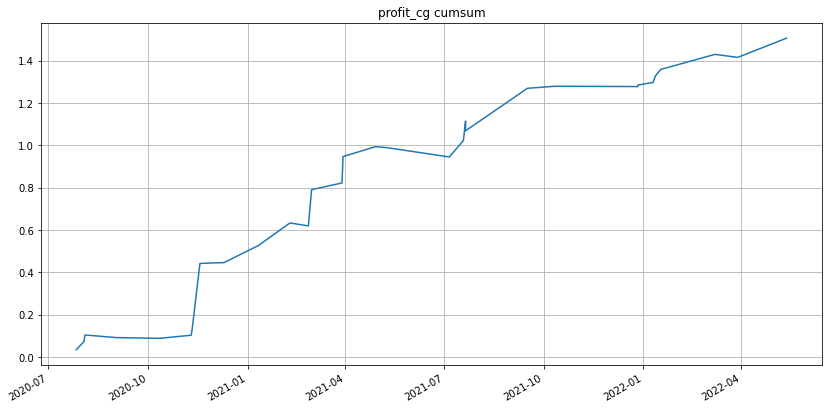

In [25]:
plt.figure(figsize=(14, 7))
metrics.order_has_ret.sort_values('buy_date')['profit_cg'].cumsum().plot(
            grid=True, title='profit_cg cumsum')

In [26]:
## 考虑资金情况下的度量，进行与benchmark的收益度量对比
print('买入后卖出的交易数量:{}'.format(metrics.order_has_ret.shape[0]))
print('买入后尚未卖出的交易数量:{}'.format(metrics.order_keep.shape[0]))

print('胜率:{:.4f}%'.format(metrics.win_rate * 100))

print('平均获利期望:{:.4f}%'.format(metrics.gains_mean * 100))
print('平均亏损期望:{:.4f}%'.format(metrics.losses_mean * 100))

print('盈亏比:{:.4f}'.format(metrics.win_loss_profit_rate))

print('策略收益: {:.4f}%'.format(metrics.algorithm_period_returns *
                                             100))
print('基准收益: {:.4f}%'.format(metrics.benchmark_period_returns *
                                             100))
print('策略年化收益: {:.4f}%'.format(
            metrics.algorithm_annualized_returns * 100))
print('基准年化收益: {:.4f}%'.format(
            metrics.benchmark_annualized_returns * 100))

print('策略买入成交比例:{:.4f}%'.format(metrics.buy_deal_rate * 100))
print('策略资金利用率比例:{:.4f}%'.format(metrics.cash_utilization * 100))
print('策略共执行{}个交易日'.format(metrics.num_trading_days))

买入后卖出的交易数量:32
买入后尚未卖出的交易数量:2
胜率:71.8750%
平均获利期望:7.1580%
平均亏损期望:-1.5583%
盈亏比:11.1401
策略收益: 18.4066%
基准收益: 22.5363%
策略年化收益: 9.1302%
基准年化收益: 11.1787%
策略买入成交比例:100.0000%
策略资金利用率比例:26.4897%
策略共执行504个交易日


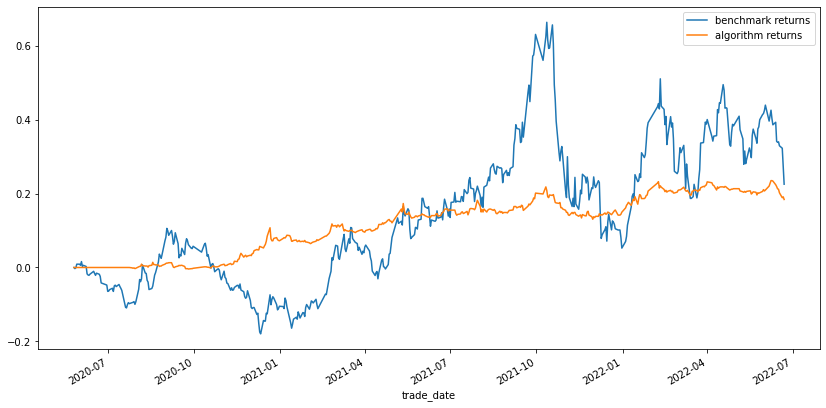

In [27]:
plt.figure(figsize=(14, 7))
metrics.benchmark_cum_returns.plot()
metrics.algorithm_cum_returns.plot()
plt.legend(['benchmark returns', 'algorithm returns'], loc='best')
plt.show()

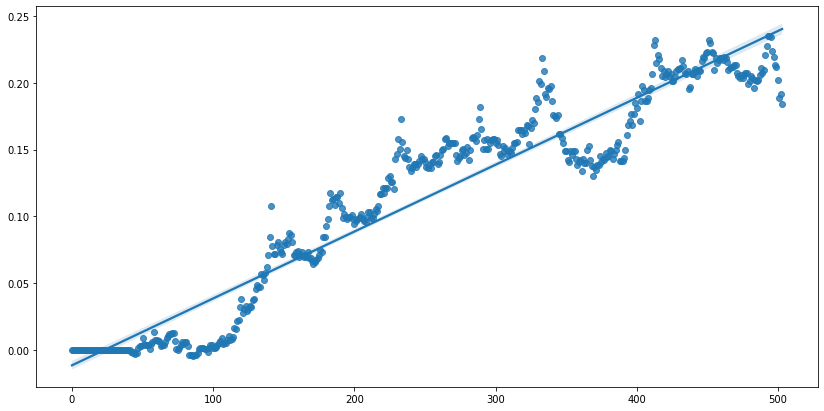

In [28]:
plt.figure(figsize=(14, 7))
sns.regplot(x=np.arange(0, len(metrics.algorithm_cum_returns)),y=metrics.algorithm_cum_returns.values)
plt.show()

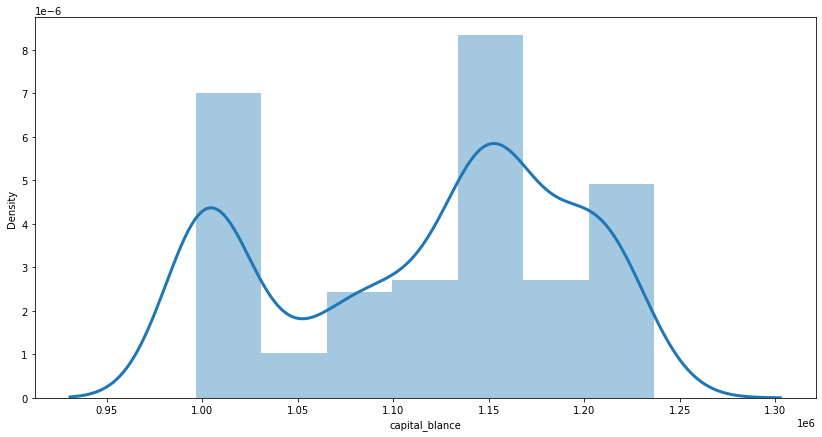

In [29]:
plt.figure(figsize=(14, 7))
sns.distplot(metrics.capital.capital_pd['capital_blance'],
                     kde_kws={
                         "lw": 3,
                         "label": "capital blance kde"
                     })
plt.show()

##### sharp，volatility的策略与基准对比

In [30]:
print('alpha阿尔法:{:.4f}'.format(metrics.alpha))
print('beta贝塔:{:.4f}'.format(metrics.beta))
print('Information信息比率:{:.4f}'.format(metrics.information))

print('策略Sharpe夏普比率: {:.4f}'.format(metrics.algorithm_sharpe))
print('基准Sharpe夏普比率: {:.4f}'.format(metrics.benchmark_sharpe))

print('策略波动率Volatility: {:.4f}'.format(
metrics.algorithm_volatility))
print('基准波动率Volatility: {:.4f}'.format(
            metrics.benchmark_volatility))

alpha阿尔法:0.0739
beta贝塔:0.0821
Information信息比率:-0.0148
策略Sharpe夏普比率: 1.1280
基准Sharpe夏普比率: 0.4610
策略波动率Volatility: 0.0777
基准波动率Volatility: 0.3641


<Figure size 1008x504 with 0 Axes>

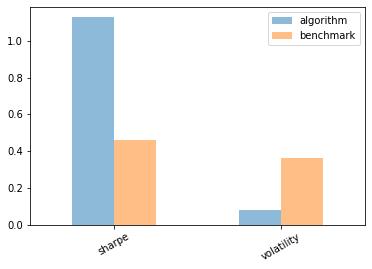

In [31]:
plt.figure(figsize=(14, 7))
sharp_volatility = pd.DataFrame(
            [[metrics.algorithm_sharpe, metrics.benchmark_sharpe],
             [metrics.algorithm_volatility, metrics.benchmark_volatility]])
sharp_volatility.columns = ['algorithm', 'benchmark']
sharp_volatility.index = ['sharpe', 'volatility']
sharp_volatility.plot(kind='bar', alpha=0.5)
_ = plt.setp(plt.gca().get_xticklabels(), rotation=30)
plt.show()

#### 度量结果的评分

In [32]:
scorer = WrsmScorer(score_tuple_array)

In [33]:
scorer.fit_score()
scorer.score_pd.tail()

,win_rate,returns,sharpe,max_drawdown,score_win_rate,score_returns,score_sharpe,score_max_drawdown,score
18,0.7692,0.0122,0.1619,-0.2570,1.0000,0.5789,0.5789,0.4211,0.6447
17,0.7333,-0.0118,-0.0506,-0.0690,0.8947,0.4211,0.4211,0.9474,0.6711
6,0.3529,0.1272,1.0847,-0.0758,0.3684,0.6316,0.9474,0.7368,0.6711
15,0.7333,-0.0041,-0.0219,-0.0465,0.8947,0.5263,0.4737,1.0000,0.7237
8,0.7188,0.1841,1.1280,-0.0719,0.8421,0.6842,1.0000,0.8421,0.8421


由于fit_score()函数的实现只是对score_pd的'score'项进行排序后返回score，这样最终的结果为分数及对应score_tuple_array的序列号，从上面输出可以看出665为最优参数序号

#### 不同权重的评分

In [34]:
# 实例化WrsmScorer，参数weights，只有第二项为1，其他都是0，
# 代表只考虑投资回报来评分
scorer = WrsmScorer(score_tuple_array, weights=[0.3, 0.3, 0.3, 0.1])
# 返回排序后的队列
scorer_returns_max = scorer.fit_score()
# 因为是倒序排序，所以index最后一个为最优参数
best_score_tuple_grid = score_tuple_array[scorer_returns_max.index[-1]]

In [35]:
metrics = MetricsBase.show_general(best_score_tuple_grid.orders_pd, best_score_tuple_grid.action_pd,
                                        best_score_tuple_grid.capital, best_score_tuple_grid.benchmark)

In [36]:
## 非真实成交的度量，认为资金无限，无资金管理的情况下总体情况
print('买入后卖出的交易数量:{}'.format(metrics.order_has_ret.shape[0]))
print('买入后尚未卖出的交易数量:{}'.format(metrics.order_keep.shape[0]))
print('胜率:{:.4f}%'.format(metrics.win_rate * 100))
print('平均获利期望:{:.4f}%'.format(metrics.gains_mean * 100))
print('平均亏损期望:{:.4f}%'.format(metrics.losses_mean * 100))
print('盈亏比:{:.4f}'.format(metrics.win_loss_profit_rate))
print('所有交易收益比例和:{:.4f} '.format(metrics.order_has_ret.profit_cg.sum()))
print('所有交易总盈亏和:{:.4f} '.format(metrics.all_profit))

买入后卖出的交易数量:32
买入后尚未卖出的交易数量:2
胜率:71.8750%
平均获利期望:7.1580%
平均亏损期望:-1.5583%
盈亏比:11.1401
所有交易收益比例和:1.5061 
所有交易总盈亏和:243950.8900 


### 自定义评分类的实现

In [37]:
class DemoScorer(BaseScorer):
    def _init_self_begin(self, *arg, **kwargs):
        """胜率，策略收益，alpha组成select_score_func"""

        self.select_score_func = lambda metrics: [metrics.win_rate, metrics.algorithm_period_returns,
                                                  metrics.alpha]
        self.columns_name = ['win_rate', 'returns', 'alpha']
        self.weights_cnt = len(self.columns_name)

    def _init_self_end(self, *arg, **kwargs):
        """
        _init_self_end这里一般的任务是将score_pd中需要反转的反转，默认是数据越大越好，有些是越小越好，
        类似make_scorer(xxx, greater_is_better=True)中的参数greater_is_better的作用：

                            sign = 1 if greater_is_better else -1
        """
        self.score_pd['alpha'] = -self.score_pd['alpha'] ## 此处为假设条件

In [38]:
scorer = DemoScorer(score_tuple_array, metrics_class=MetricsDemo)
# 返回按照评分排序后的队列
scorer_returns_max = scorer.fit_score()
scorer.score_pd.sort_values(by='alpha').tail()

,win_rate,returns,alpha,score_win_rate,score_returns,score_alpha,score
11,0.1282,-0.1087,0.0327,0.2105,0.1579,0.7895,0.3860
10,0.4390,-0.0976,0.0444,0.5263,0.2105,0.8421,0.5263
0,0.4778,-0.1101,0.0455,0.5789,0.1053,0.8947,0.5263
12,0.3902,-0.3215,0.1653,0.4211,0.0526,0.9474,0.4737
2,0.5169,-0.3400,0.1776,0.6316,0.0000,1.0000,0.5439
